In [5]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

In [6]:
target = "close_percent_change"

In [7]:
# Load model
# model = pickle.load(open("../model/xgboost_model.pkl", "rb"))


model = xgb.XGBRegressor()
model.load_model("../model/xgboost_model.json")

In [8]:
# load predictions
df = pd.read_parquet("../data/predicted.parquet")

In [9]:
def normalize_column(data: pd.DataFrame, column: str | list) -> pd.DataFrame:
    if isinstance(column, str):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
    elif isinstance(column, list):
        for col in column:
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

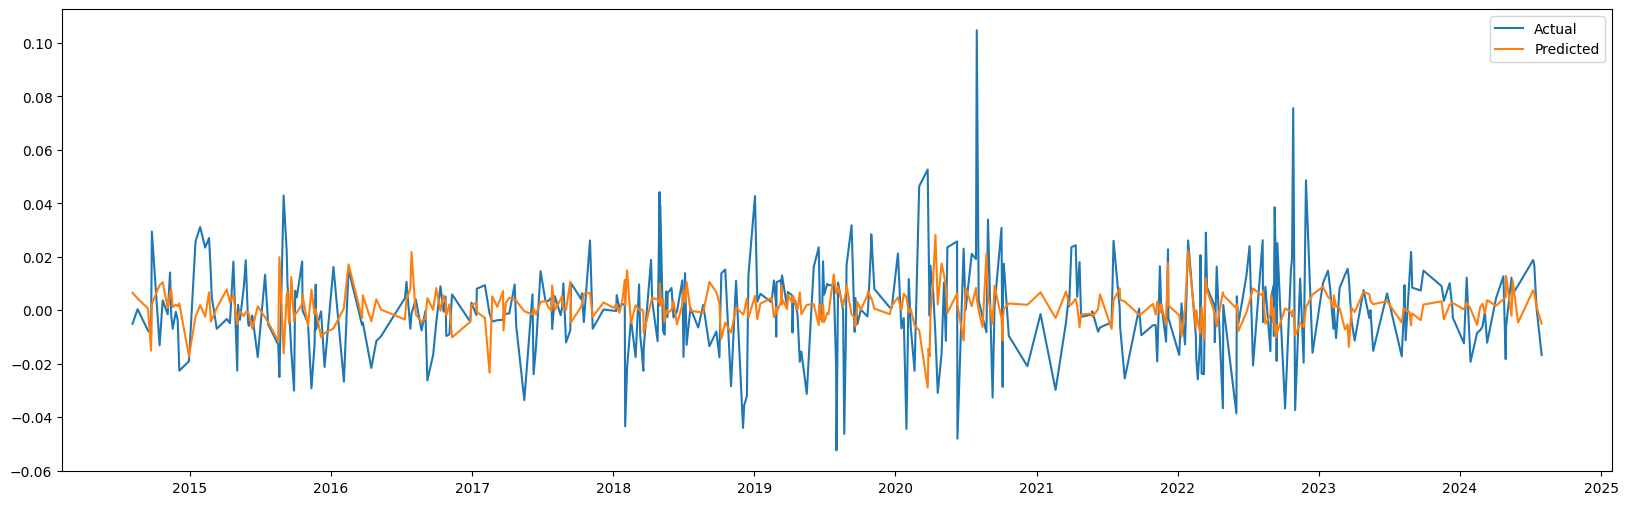

In [10]:
# Plot the predicted vs actual values
plt.figure(figsize=(20, 6))
plt.plot(df[target], label="Actual")
plt.plot(df["predicted"], label="Predicted")
plt.legend()
plt.show()

<Axes: xlabel='date', ylabel='value'>

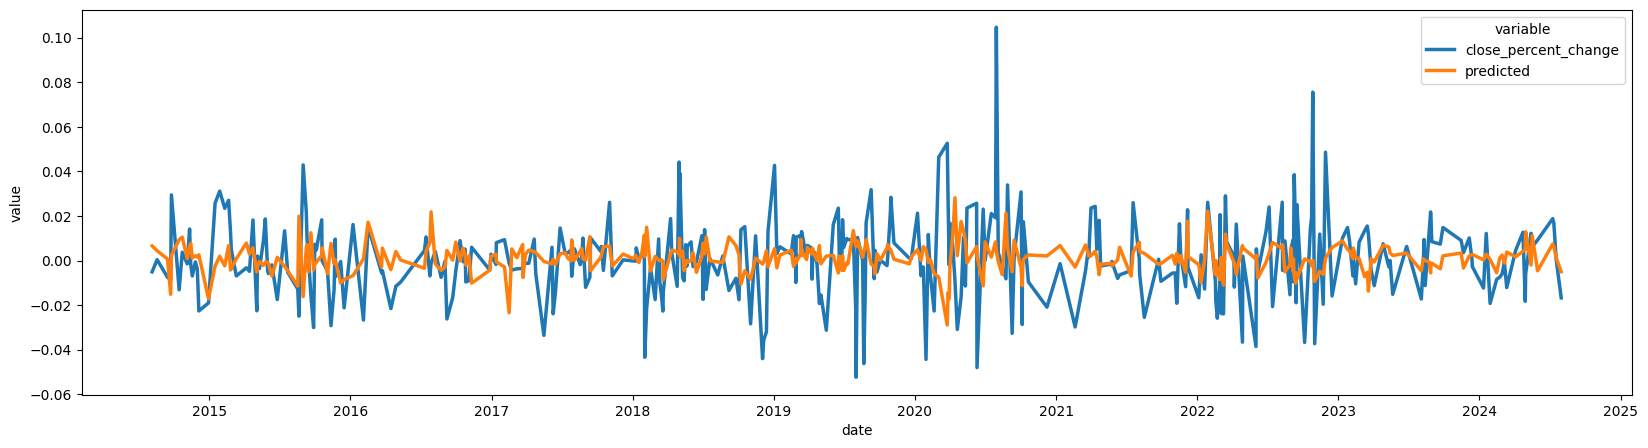

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(
    df.reset_index().melt(id_vars=["date"], value_vars=["close_percent_change", "predicted"]),
    y="value",
    x="date",
    hue="variable",
    linewidth=2.5,
    ax=ax,
)

In [12]:
df_importance = pd.DataFrame()

importance_types = ["weight", "gain", "cover", "total_gain", "total_cover"]
for importance_type in importance_types:
    importance = model.get_booster().get_score(importance_type=importance_type)

    df_i = pd.DataFrame(importance.items(), columns=["feature", importance_type])

    if df_importance.empty:
        df_importance = df_i
    else:
        df_importance = pd.merge(df_importance, df_i, on="feature", how="outer")
df_importance


,feature,weight,gain,cover,total_gain,total_cover
0,adj close,44.0,0.000335,78.704544,0.014736,3463.0
1,close,67.0,0.000143,33.104477,0.009583,2218.0
2,day_of_month,67.0,0.000509,351.462677,0.034072,23548.0
3,day_of_week,22.0,0.000457,88.363640,0.010047,1944.0
4,dividends_event_decay,195.0,0.000237,161.005127,0.046296,31396.0
...,...,...,...,...,...,...
247,volume_lag_7,93.0,0.000420,354.795685,0.039014,32996.0
248,volume_lag_8,96.0,0.000419,379.072906,0.040241,36391.0
249,volume_lag_9,121.0,0.000528,383.090912,0.063842,46354.0
250,week_of_year,47.0,0.000467,103.617020,0.021926,4870.0


In [13]:
df_importance = normalize_column(df_importance, ["weight", "gain", "cover", "total_gain", "total_cover"])
df_importance_melted = df_importance.sort_values(by="weight", ascending=True).melt(id_vars=["feature"], value_vars=importance_types)
# df_importance

<Axes: xlabel='value', ylabel='feature'>

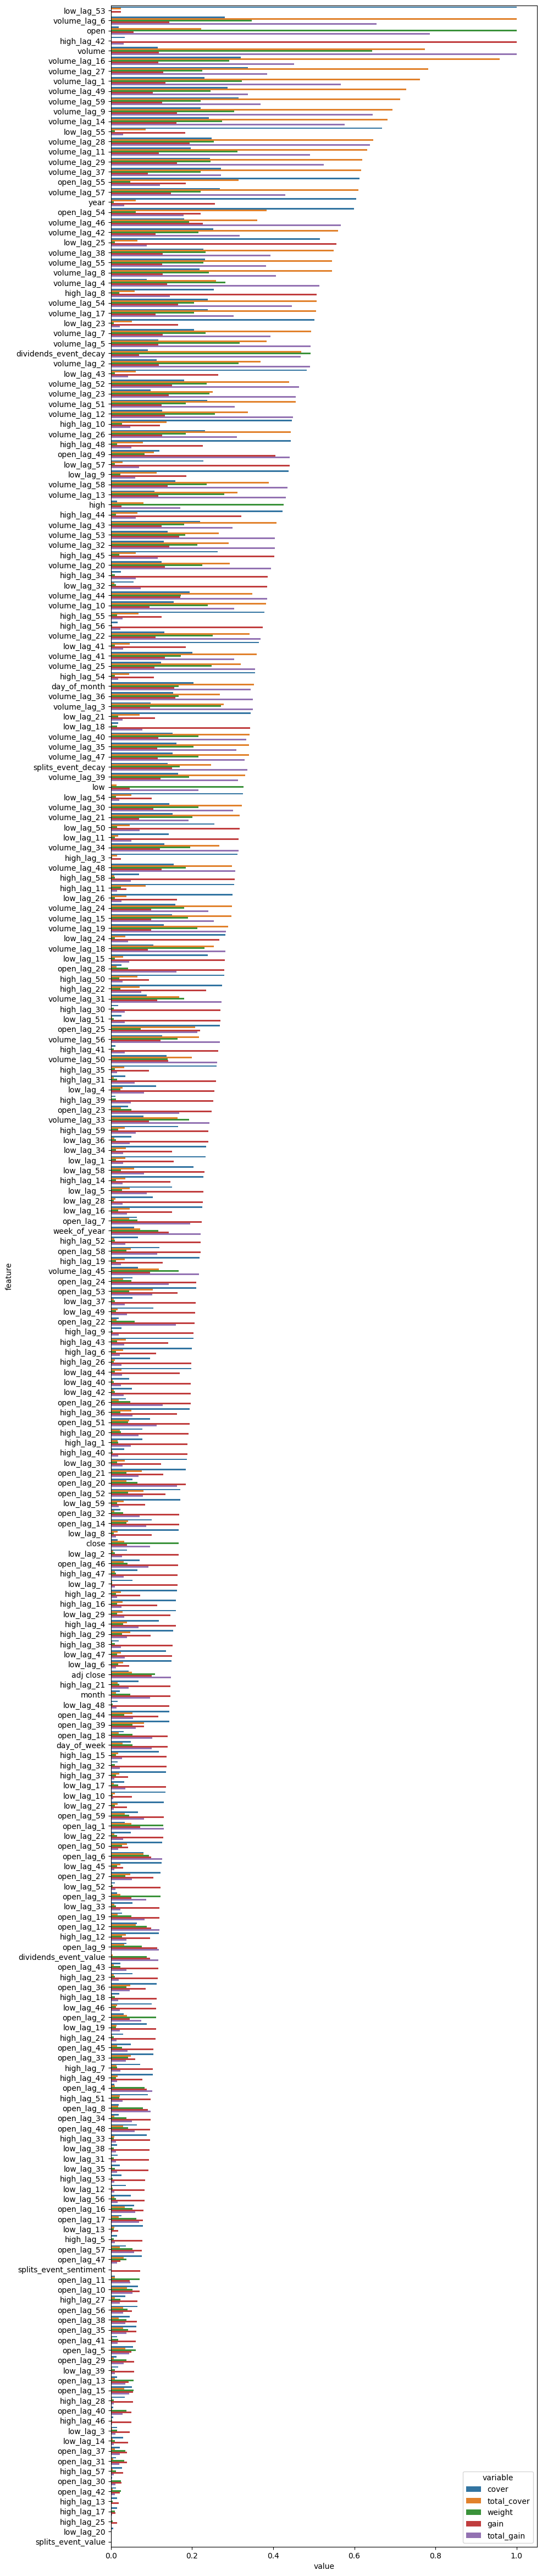

In [16]:
fig, ax = plt.subplots(figsize=(10, 60))
sns.barplot(
    df_importance
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)

<Axes: xlabel='value', ylabel='feature'>

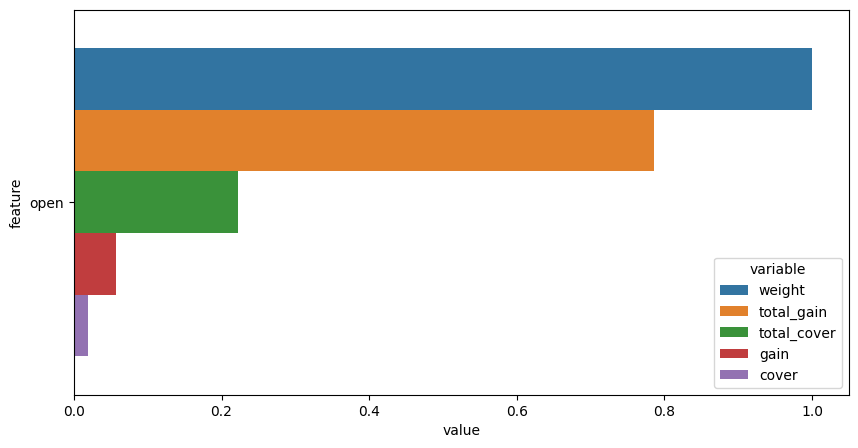

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    df_importance[df_importance["feature"] == "open"]
    .melt(id_vars=["feature"], value_vars=importance_types).sort_values(by="value", ascending=False),
    y="feature",
    x="value",
    hue="variable",
    ax=ax,
)